In [198]:
import json
import urllib 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme as gev
import pandas as pd
import datetime 

In [199]:
params = {}
url='https://aqs.epa.gov/data/api/list/parametersByClass?email=samavedamanjali@gmail.com&key=russetcrane95&pc=CRITERIA'
with urllib.request.urlopen(url) as urlhandle:
    params = json.loads(urlhandle.read().decode())

params_dict = {}
for i in params['Data']:
    #print (i['code'], i['value_represented'])
    params_dict[i['code']] = i['value_represented']
del params_dict['14129']  # Some issue with data for this; ignore for now
del params_dict['81102']
del params_dict['85129']
print (params_dict)

{'42101': 'Carbon monoxide', '42401': 'Sulfur dioxide', '42602': 'Nitrogen dioxide (NO2)', '44201': 'Ozone', '88101': 'PM2.5 - Local Conditions'}


In [200]:
params_dict = {'42101': 'CarbonMonoxide', '42401': 'SulfurDioxide', '42602': 'NitrogenDioxide', '44201': 'Ozone', '88101': 'PM2.5LocalConditions'}

In [201]:
def readAndDisplayFile(c,p,y):
    f_name = '../Anjali/data/'+c+p+'_'+y+'.json'
    with open(f_name) as json_file:
        data = json.load(json_file)
        #print(data)
        df = pd.DataFrame.from_dict(data['Data'])

        if (df.size != 0) :
            # get only the needed cols out of 30+ columns
            df = df[['date_local','arithmetic_mean']]
            # agggregate by date so that we have one value per day
            df = df.groupby('date_local').mean().reset_index()
        return df;

In [208]:
def readAndDisplayFileYearRange(c,px,ya,yb):
    #print(c,px,ya,yb)
    df_ab = pd.DataFrame()
    for y in range(ya,yb):
        df1 = readAndDisplayFile('WashDC',px,str(y));
        df_ab = df_ab.append(df1)
    return df_ab
    
#df = readAndDisplayFile('Baltimore','p','2011');

(-0.5015819929550804, 2.9961353779587996, 1.0017480841258783)
(-0.5068603659863826, 2.999161708806385, 1.0305462704015094)
(-0.06814331241400648, 10.064278600874225, 4.7022244789603755)
(-0.6526722226629056, 3.621057873973146, 3.902134995832234e-30)
(-0.05701049848342438, 7.44172970514134, 3.498645405332815)


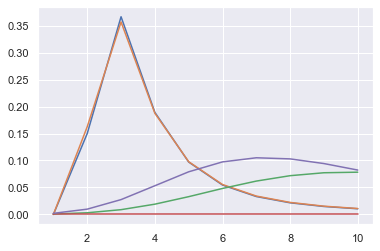

In [209]:
for p in params_dict.keys():
    df_10 = readAndDisplayFileYearRange('WashDC',p,2010,2020)
    dataN = df_10['arithmetic_mean'].tolist()
    t = np.linspace(1,10,10)
    fit = gev.fit(dataN,loc=3)
    pdf = gev.pdf(t, *fit)
    plt.plot(t, pdf)
    #plt.plot(t, dataN, "o")
    print(fit)


42101 CarbonMonoxide
42401 SulfurDioxide
42602 NitrogenDioxide
44201 Ozone
88101 PM2.5LocalConditions


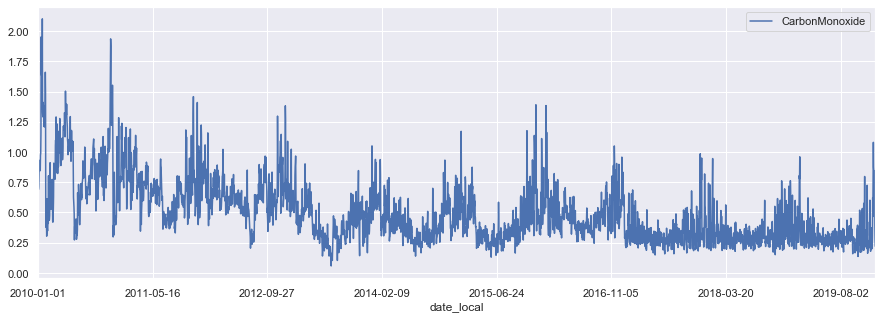

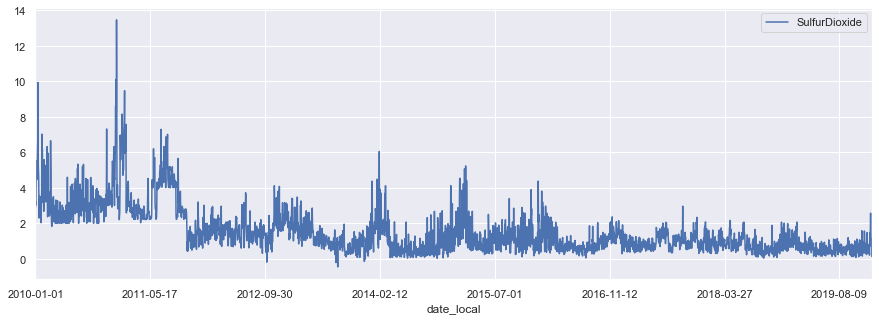

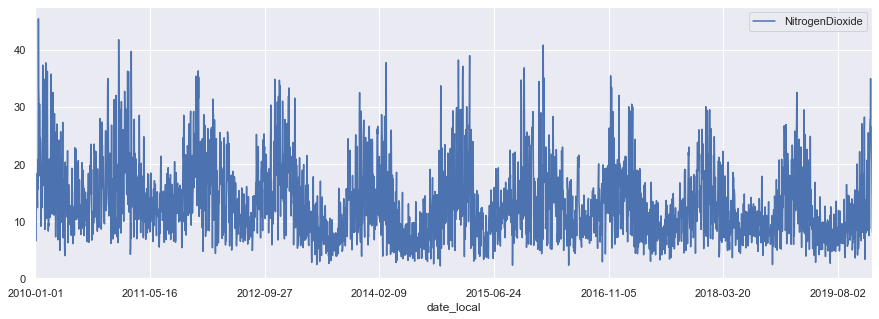

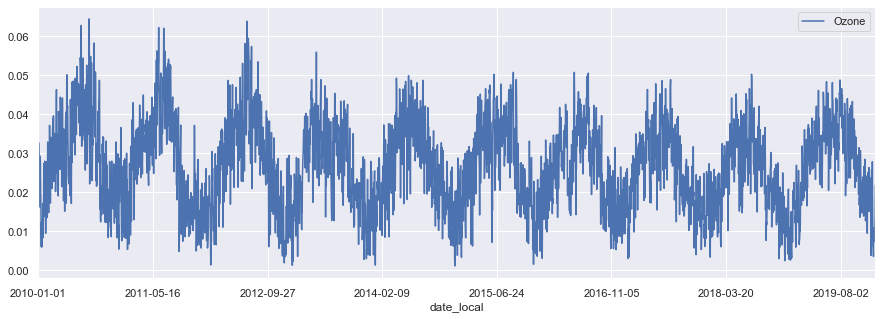

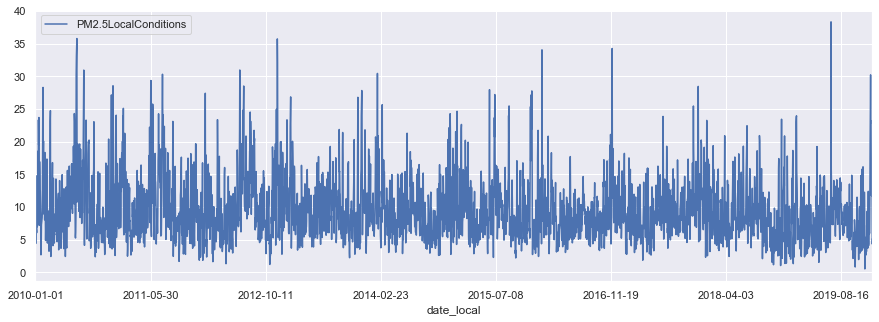

In [210]:

for p in params_dict.keys():
    print(p, params_dict[p])

    df = readAndDisplayFileYearRange('Baltimore',p,2010,2020)    
    df.columns = ['date_local', params_dict[p]]
    df.groupby('date_local').mean().plot(figsize=(15,5))



In [211]:
def dayofyear():
    x = datetime.date(2019, 4, 13)
    y = datetime.date(2019,4,14)
    one_day = y-x
    num_days = datetime.date(2011, 12, 31) - datetime.date(2010, 1, 1)
    begin = datetime.date(2010, 1, 1)
    end = datetime.date(2011, 12, 31)
    for d in range(0, num_days.days):
        newDate = (str(begin + (d*one_day)))
        print(newDate)
    return newDate

#dayofyear()

In [212]:
df_master = {}

for p in params_dict.keys():
    print(p, params_dict[p])
    df = readAndDisplayFileYearRange('Baltimore',p,2010,2020)    
    #df.columns = ['date_local', params_dict[p]]
    df_master[p] = df;   


42101 CarbonMonoxide
42401 SulfurDioxide
42602 NitrogenDioxide
44201 Ozone
88101 PM2.5LocalConditions


In [213]:
for p in params_dict.keys():
    print (p,df_master[p].shape)

42101 (3652, 2)
42401 (3645, 2)
42602 (3652, 2)
44201 (3652, 2)
88101 (3638, 2)


In [214]:
def combineParamCols(ya,yb):
    x = datetime.date(2019, 1, 1)
    y = datetime.date(2019,1,2)
    one_day = y-x

    begin = datetime.date(ya, 1, 1)
    end = datetime.date(yb, 12, 31)
    num_days = end - begin
    print(begin, end)
    data_master = {}
    data_master['date_local'] = []
    for p in params_dict.keys():
        data_master[p] = []

    df_new = pd.DataFrame(data_master)            

    for d in range(0, num_days.days):
        new_date = str(begin + (d*one_day))
        data_master['date_local'].append(new_date)
        for p in params_dict.keys():
            df = df_master[p]
            try:
                val = df[df.date_local==new_date]['arithmetic_mean'].values[0]
                #print(new_date,p, val)
                data_master[p].append(val)
                #print (data_master[p])
            except:
                data_master[p].append(0) #### TBD to think about missing data later 

    return pd.DataFrame(data_master)           


In [215]:
y=2011
df_comb = combineParamCols(y,y)
corrmat = df_comb.corr()
yrly_corrs = {}    
for y in range(2010, 2020):
    df_comb = combineParamCols(y,y)
    yrly_corrs[y] = df_comb.corr()
    


2011-01-01 2011-12-31
2010-01-01 2010-12-31
2011-01-01 2011-12-31
2012-01-01 2012-12-31
2013-01-01 2013-12-31
2014-01-01 2014-12-31
2015-01-01 2015-12-31
2016-01-01 2016-12-31
2017-01-01 2017-12-31
2018-01-01 2018-12-31
2019-01-01 2019-12-31


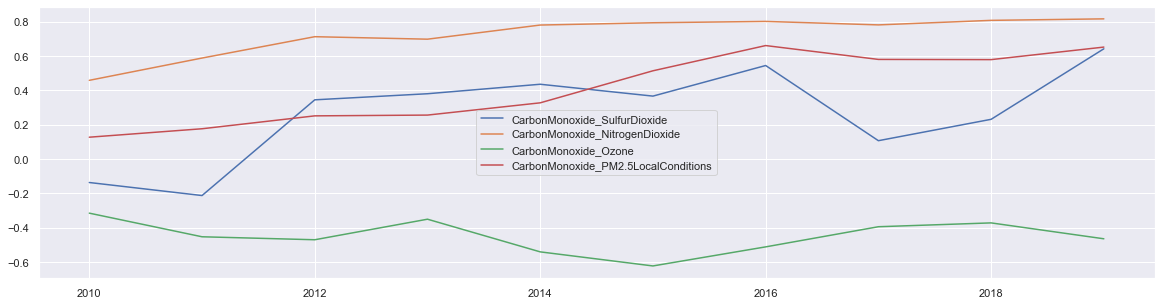

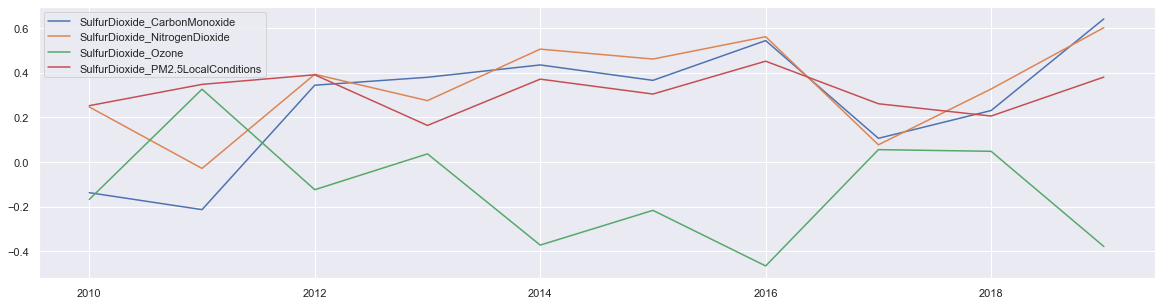

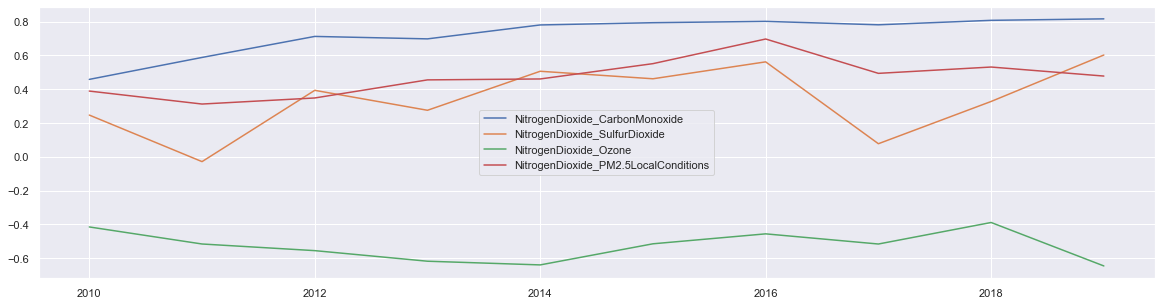

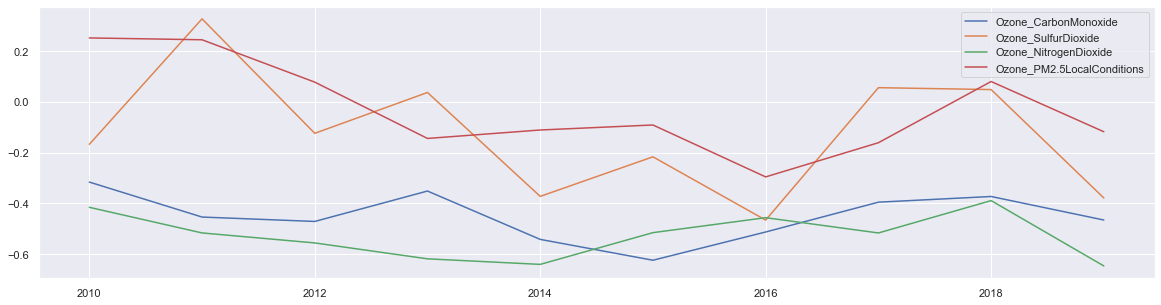

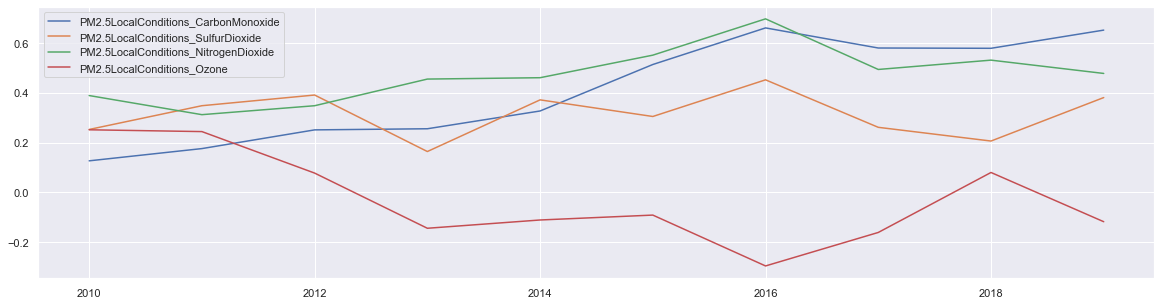

In [216]:
corr_dict = {}
x_ax = []
for y in range(2010, 2020):
    x_ax.append(y)


for pa in params_dict.keys():
    per_par_dict = {}
    corr_dict[pa]=per_par_dict
    plt.figure(figsize=(20,5)) #  width, height

    for pb in params_dict.keys():
        if pa == pb:
            continue
        per_par_dict[pb] = []
        for y in range(2010, 2020):
            per_par_dict[pb].append(yrly_corrs[y][pa][pb])
        lbl = params_dict[pa]+'_'+params_dict[pb]
        plt.plot(x_ax,per_par_dict[pb],label=lbl)
    plt.legend(loc='best')
    plt.show()

#corr_dict

2015-01-01 2015-12-31


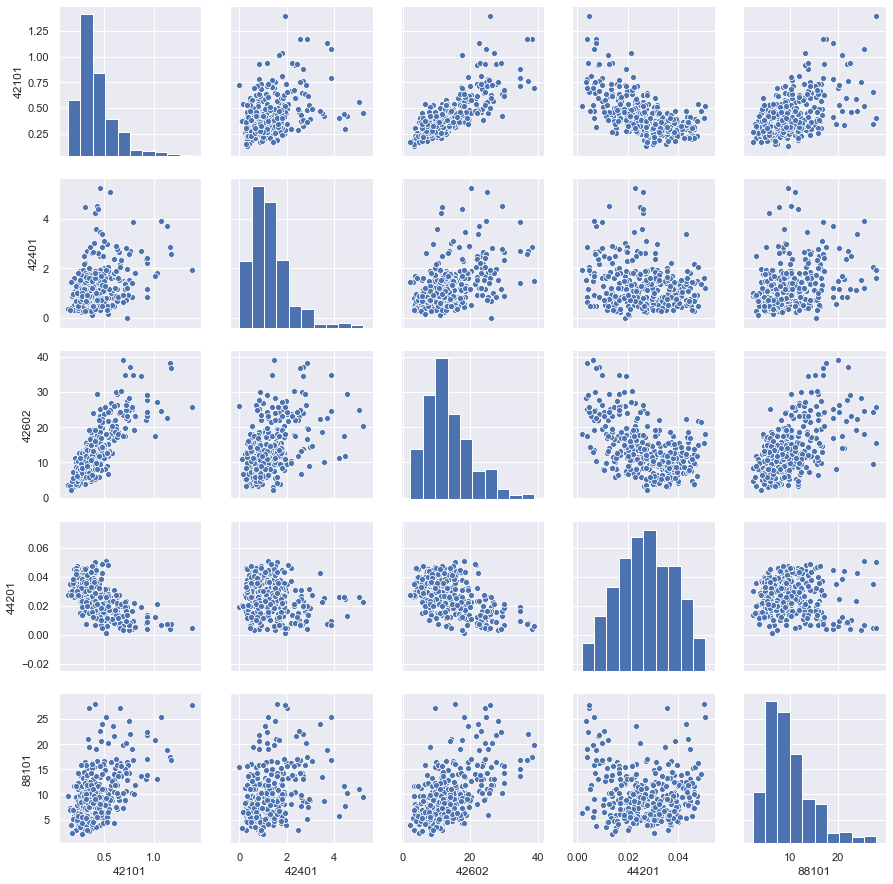

In [217]:
df_comb = combineParamCols(2015,2015)
sns.set()
cols = params_dict.keys()
sns.pairplot(df_comb[cols], height=2.5)
#plt.show()